<a href="https://colab.research.google.com/github/elichen/adventofcode/blob/main/Day_17_Reservoir_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
data = """x=495, y=2..7
y=7, x=495..501
x=501, y=3..7
x=498, y=2..4
x=506, y=1..2
x=498, y=10..13
x=504, y=10..13
y=13, x=498..504""".split('\n')

In [195]:
data = [x.rstrip() for x in open("input.txt").readlines()]

In [196]:
import numpy as np

def parse_ranges(strings):
    # Parse the input strings to extract x and y ranges
    x_ranges = []
    y_ranges = []
    for string in strings:
        parts = string.split(', ')
        for part in parts:
            axis, range_ = part.split('=')
            if '..' in range_:
                start, end = map(int, range_.split('..'))
                range_list = list(range(start, end + 1))
            else:
                range_list = [int(range_)]

            if axis == 'x':
                x_ranges.extend(range_list)
            elif axis == 'y':
                y_ranges.extend(range_list)

    # Determine the size of the array
    min_x, max_x = min(x_ranges)-1, max(x_ranges)+1
    min_y, max_y = min(y_ranges), max(y_ranges)
    width, height = max_x - min_x + 1, max_y - min_y + 1

    # Create the array and mark the cells
    array = np.zeros((height, width), dtype=int)
    for string in strings:
        parts = string.split(', ')
        for part in parts:
            axis, range_ = part.split('=')
            if '..' in range_:
                start, end = map(int, range_.split('..'))
            else:
                start = end = int(range_)

            if axis == 'x':
                x_start, x_end = start - min_x, end - min_x
            elif axis == 'y':
                y_start, y_end = start - min_y, end - min_y

        # Mark the cells in the array
        array[y_start:y_end + 1, x_start:x_end + 1] = 1

    return array, (min_x, min_y)

array, offsets = parse_ranges(data)

In [197]:
def simulate_water(array, x_offset, y_offset, start_x=500, start_y=-1):
    # Constants for cell types
    EMPTY, WALL, STILL_WATER, MOVING_WATER = 0, 1, 2, 3

    # Adjust start_x according to the offset
    start_x -= x_offset

    # Create a copy of the array to simulate on
    sim_array = np.copy(array)

    def can_move_to(x, y):
        """Check if the water can move to the given position."""
        if 0 <= y < sim_array.shape[0] and 0 <= x < sim_array.shape[1]:
            return sim_array[y, x] in [EMPTY, MOVING_WATER]
        return False

    def is_empty(x, y):
        if 0 <= y < sim_array.shape[0] and 0 <= x < sim_array.shape[1]:
            return sim_array[y, x] == EMPTY
        return False

    def is_supported(x, y):
        """Check if there is a wall or still water directly under the given position."""
        return 0 <= y + 1 < sim_array.shape[0] and sim_array[y + 1, x] in [WALL, STILL_WATER]

    def can_create_still_water(x, y):
        """Check if still water can be created by testing support on both sides up to the nearest walls."""
        # Check left side
        left_x = x
        while left_x >= 0 and sim_array[y, left_x] != WALL:
            if not is_supported(left_x, y):
                return False
            left_x -= 1
        # Check right side
        right_x = x
        while right_x < sim_array.shape[1] and sim_array[y, right_x] != WALL:
            if not is_supported(right_x, y):
                return False
            right_x += 1
        return True

    def mark_still_water(x, y):
        """Mark still water from the current position to both walls."""
        left_wall = next(x_check for x_check in range(x, -1, -1) if sim_array[y, x_check] == WALL)
        right_wall = next(x_check for x_check in range(x, sim_array.shape[1]) if sim_array[y, x_check] == WALL)
        for x_fill in range(left_wall + 1, right_wall):
            sim_array[y, x_fill] = STILL_WATER

    def drop_water(droplet_queue):
        """Simulate a droplet based on the queue."""
        while droplet_queue:
            x, y, direction = droplet_queue.popleft()

            while True:
                if y >= sim_array.shape[0] - 1:  # Drop has fallen off the array
                    break

                if can_move_to(x, y + 1):  # Move down if possible
                    y += 1
                    direction = 0
                elif direction == 0:  # When reaching the ground, split the droplet
                    if can_create_still_water(x, y):
                        mark_still_water(x, y)
                        droplet_queue.append((x, y-1, 0))
                    else:
                      sim_array[y, x] = MOVING_WATER
                      if is_empty (x-1, y): droplet_queue.append((x, y, -1))
                      if is_empty (x+1, y): droplet_queue.append((x, y, 1))
                    break
                elif can_move_to(x + direction, y):
                    x += direction
                else:
                    break

                sim_array[y, x] = MOVING_WATER  # Mark the cell as moving water

    # Initialize the droplet queue and simulate water drops
    droplet_queue = deque([(start_x, start_y, 0)])
    drop_water(droplet_queue)

    return sim_array

# Test the modified function with the array and offsets from earlier
new_array = simulate_water(array, *offsets)

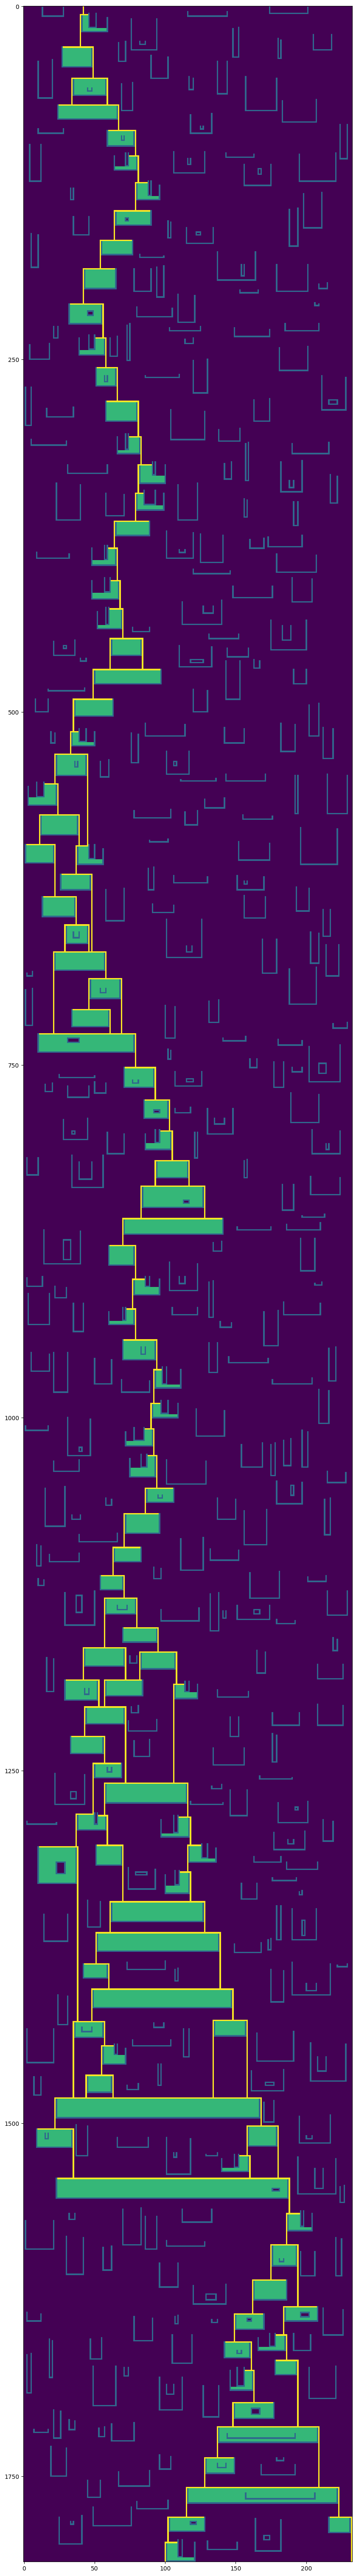

In [198]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 100))
plt.imshow(new_array, cmap='viridis', origin='upper')
plt.show()

In [199]:
np.count_nonzero(new_array >= 2)

34291

In [200]:
np.count_nonzero(new_array == 2)

28487